# Training of an autoencoder using a subset of the images

In [2]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg

2023-04-03 19:27:54.358184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
noise_filter = True

## Reading and normalizing the images

In [4]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    file_list = [f for f in file_list if f not in noise_imgs]

AIA193_2016 = sunpy.map.Map(file_list)


AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))
AIA193_2016_matrix = np.clip(AIA193_2016_matrix, 0, 5000)

# Normalize images
min_values = AIA193_2016_matrix.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = AIA193_2016_matrix.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)) # To avoid dividing by 0

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values) / rg

input_train, input_test = train_test_split(AIA193_2016_mnorm, test_size=0.25)

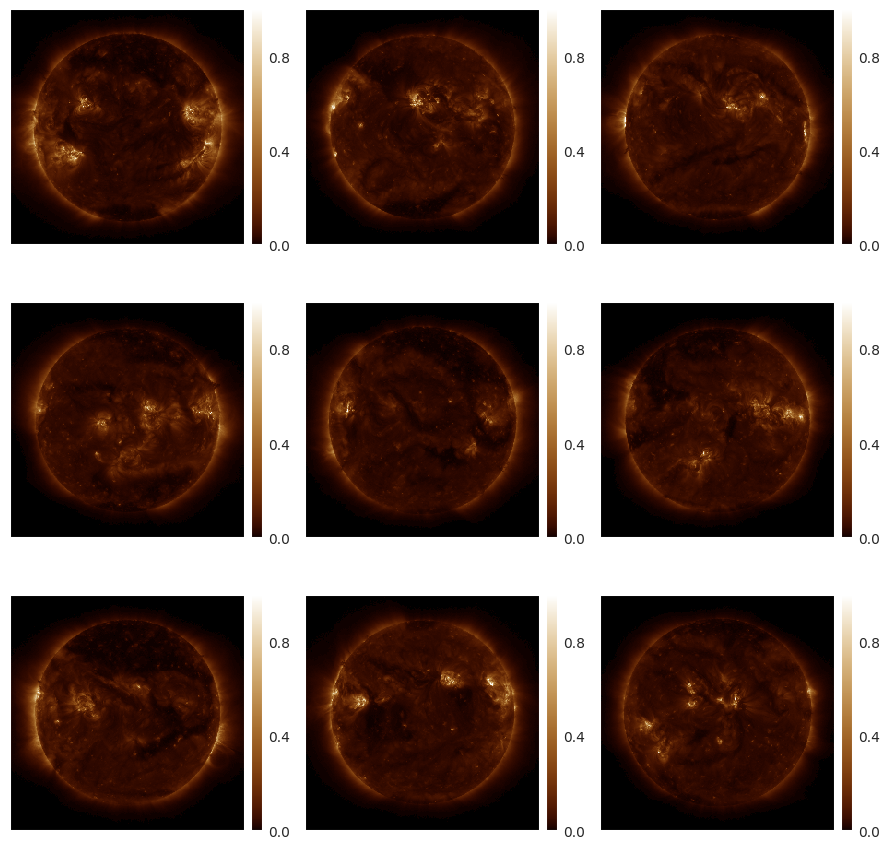

In [5]:
aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
isns.ImageGrid([i for i in AIA193_2016_mnorm[:9]], cmap=aia193_colormap)

## Training the model

In [6]:
latent_size = 48
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD()
autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim=optimizer, loss="mse")

2023-04-03 19:28:12.411455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-03 19:28:12.428357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-03 19:28:12.428640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      2320      
                                                             

In [7]:
n_epochs = 125
batch_size = 128

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/125


2023-04-03 19:28:16.163502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-03 19:28:17.290021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 13s 229ms/step - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0033 - val_mae: 0.0345
Epoch 2/125
14/14 [==============================] - 1s 84ms/step - loss: 0.0029 - mae: 0.0324 - val_loss: 0.0026 - val_mae: 0.0283
Epoch 3/125
14/14 [==============================] - 1s 83ms/step - loss: 0.0024 - mae: 0.0273 - val_loss: 0.0024 - val_mae: 0.0290
Epoch 4/125
14/14 [==============================] - 1s 84ms/step - loss: 0.0022 - mae: 0.0250 - val_loss: 0.0021 - val_mae: 0.0222
Epoch 5/125
14/14 [==============================] - 1s 83ms/step - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0019 - val_mae: 0.0223
Epoch 6/125
14/14 [==============================] - 1s 83ms/step - loss: 0.0019 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0203
Epoch 7/125
14/14 [==============================] - 1s 83ms/step - loss: 0.0018 - mae: 0.0199 - val_loss: 0.0018 - val_mae: 0.0192
Epoch 8/125
14/14 [==============================] - 1s 84ms/step - loss: 0.0017 - mae

## Evaluating the model

20/20 [==============================] - 1s 21ms/step - loss: 7.1138e-04 - mae: 0.0116


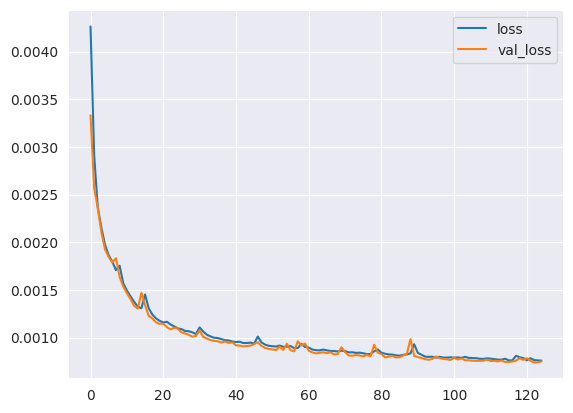

In [8]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 163ms/step


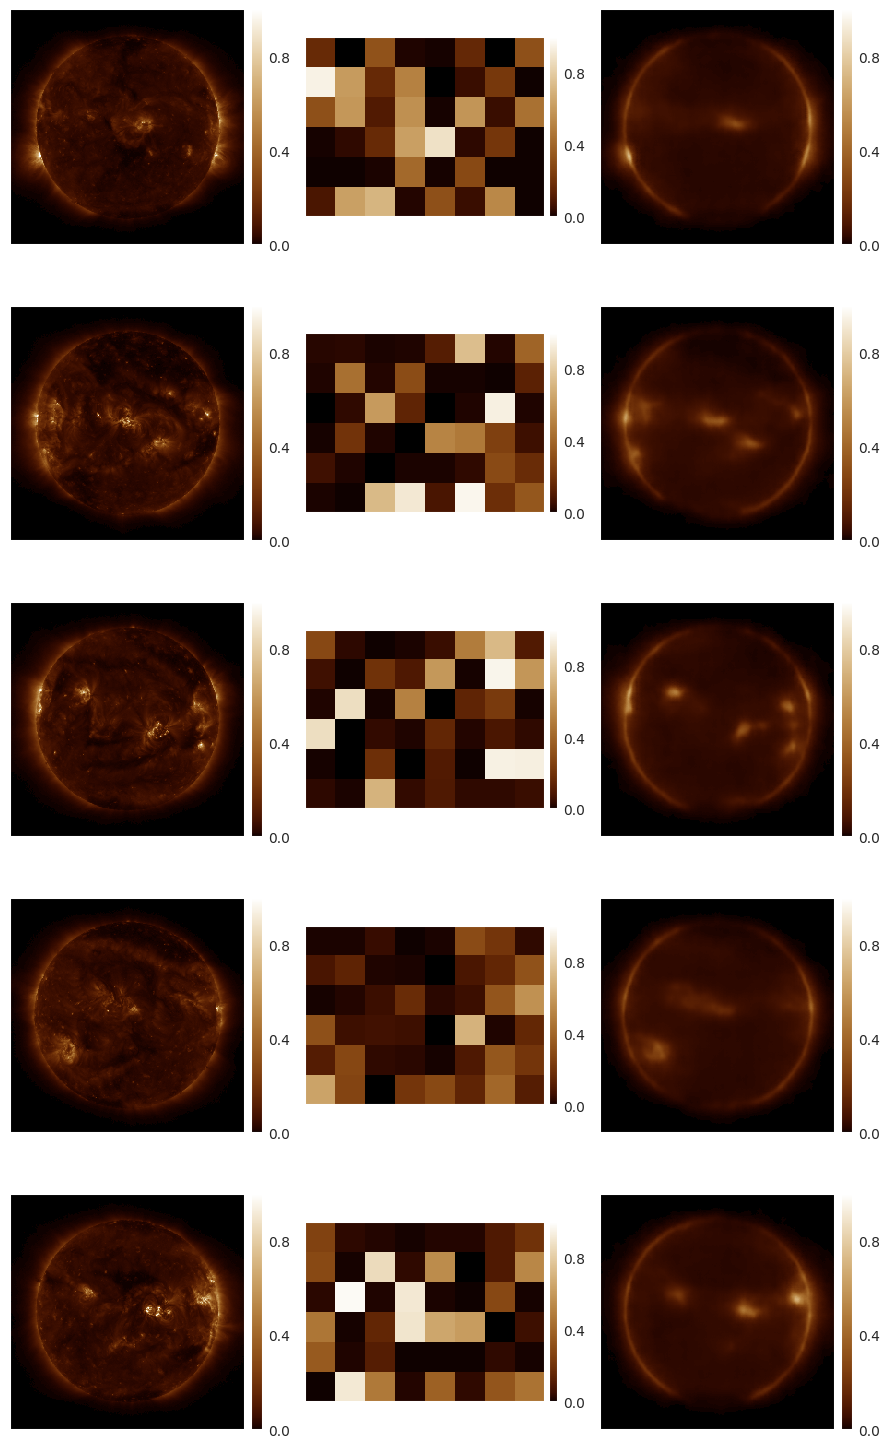

In [9]:
idx = np.random.permutation(80)[:5]

example = input_test[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

1/1 [==============================] - 0s 15ms/step


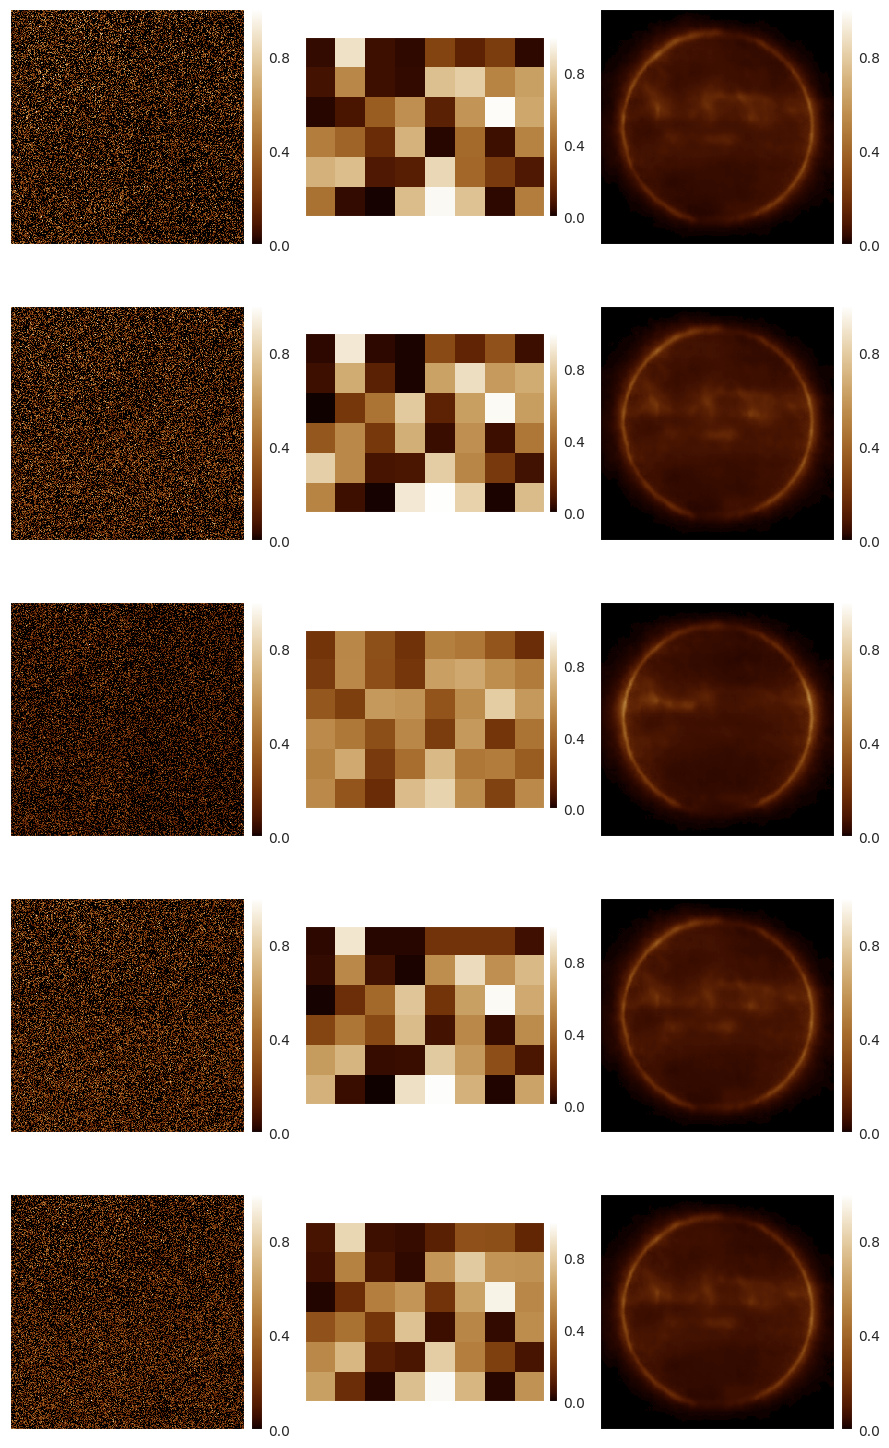

In [10]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

noisy_file_list = [f for f in file_list if f in noise_imgs]

AIA193_2016_noise = sunpy.map.Map(noisy_file_list)
AIA193_2016_matrix_noise = np.array(list(d.data for d in AIA193_2016_noise))

# Normalize images
AIA193_2016_matrix_noise = np.clip(AIA193_2016_matrix_noise, 0, 5000)
min_values = AIA193_2016_matrix_noise.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = AIA193_2016_matrix_noise.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)) # To avoid dividing by 0

AIA193_2016_mnorm_noise = (AIA193_2016_matrix_noise-min_values) / rg

idx = np.random.permutation(len(noisy_file_list))[:5]

example = AIA193_2016_mnorm_noise[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

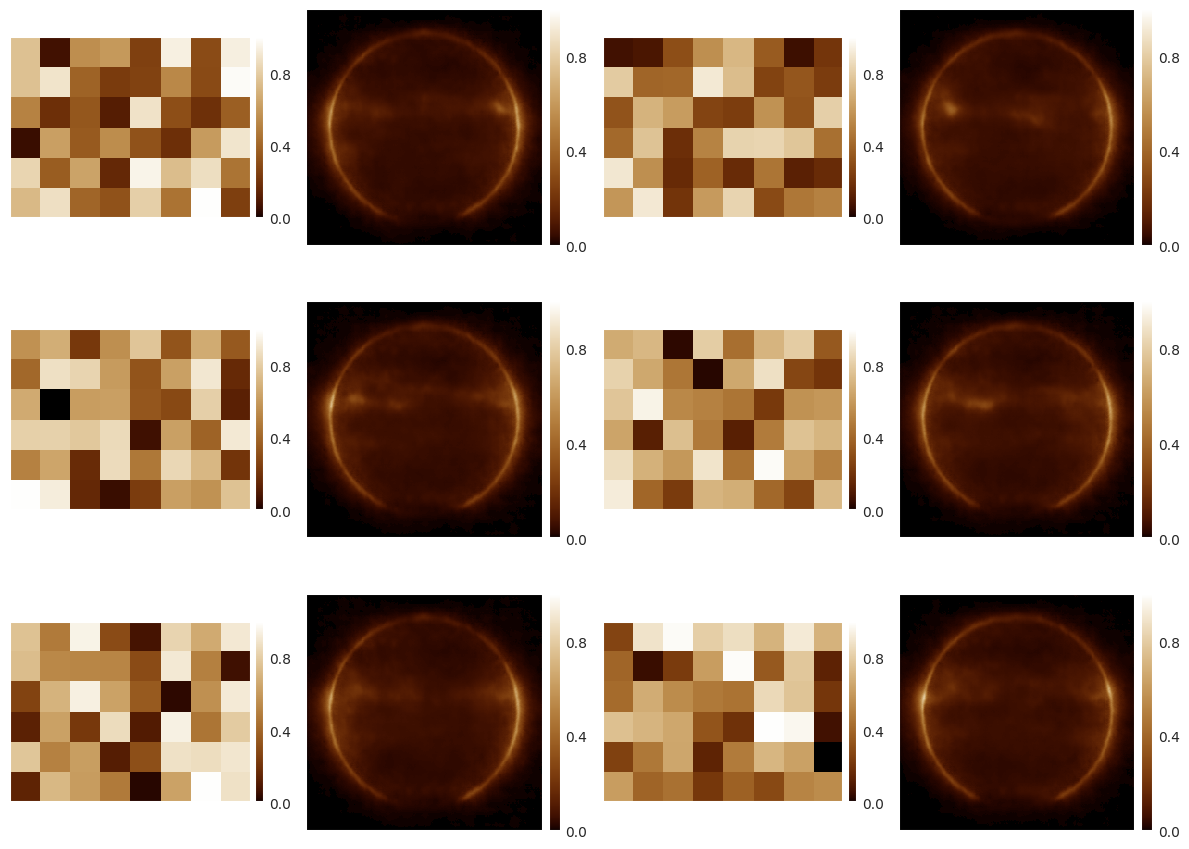

In [12]:
code = np.random.uniform(0, 1, [6, latent_size])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [6,8]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=4)